In [28]:
from openai import OpenAI
import os
from dotenv import load_dotenv
import base64
import mimetypes
from PIL import Image
from io import BytesIO
import pandas as pd
from io import StringIO
import fitz
load_dotenv()

True

In [7]:
client = OpenAI(
    api_key=os.getenv('OPENAI_API_KEY'))

In [30]:
os.mkdir('images/biedronka20112023-25112023')
doc = fitz.open("images/biedronka20112023-25112023.pdf")

for idx in range(doc.page_count):
    # Select the page you want to convert (0 for the first page)
    page = doc.load_page(idx)

    # Convert it to a pixmap (an image)
    pix = page.get_pixmap()

    # Save the image
    image_path = f"images/biedronka20112023-25112023/page{idx}.png"
    pix.save(image_path)

# Close the document
doc.close()

In [18]:
def chat(query, image_path):
    # Guess the MIME type of the image
    mime_type, _ = mimetypes.guess_type(image_path)
    if not mime_type or not mime_type.startswith('image'):
        raise ValueError("The file type is not recognized as an image")
    
    # Read the image binary data
    with open(image_path, 'rb') as image_file:
        image_data = image_file.read()
        encoded_string = base64.b64encode(image_data).decode('utf-8')
    
    # Format the result with the appropriate prefix
    image_base64 = f"data:{mime_type};base64,{encoded_string}"

    # Read image for size using PIL
    image = Image.open(BytesIO(image_data))
    width, height = image.size
    print("Width:", width, "Height:", height)
    # Display the image
    display(image)
    

    response = client.chat.completions.create(
        model="gpt-4-vision-preview",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": query},
                    {
                        "type": "image_url",
                        "image_url": {"url": image_base64, "detail": "high"}
                    },
                ],
            }
        ],
        max_tokens=300,
    )

    return response.choices[0].message.content

In [24]:
query = 'You are given a page from a polish grocery shop offer. I need a list of items on this offer, their category, discounts applied and price if it is known. Return in a format: product/category/discount/price new line. Return only this format and nothing else. '

Width: 1932 Height: 1526


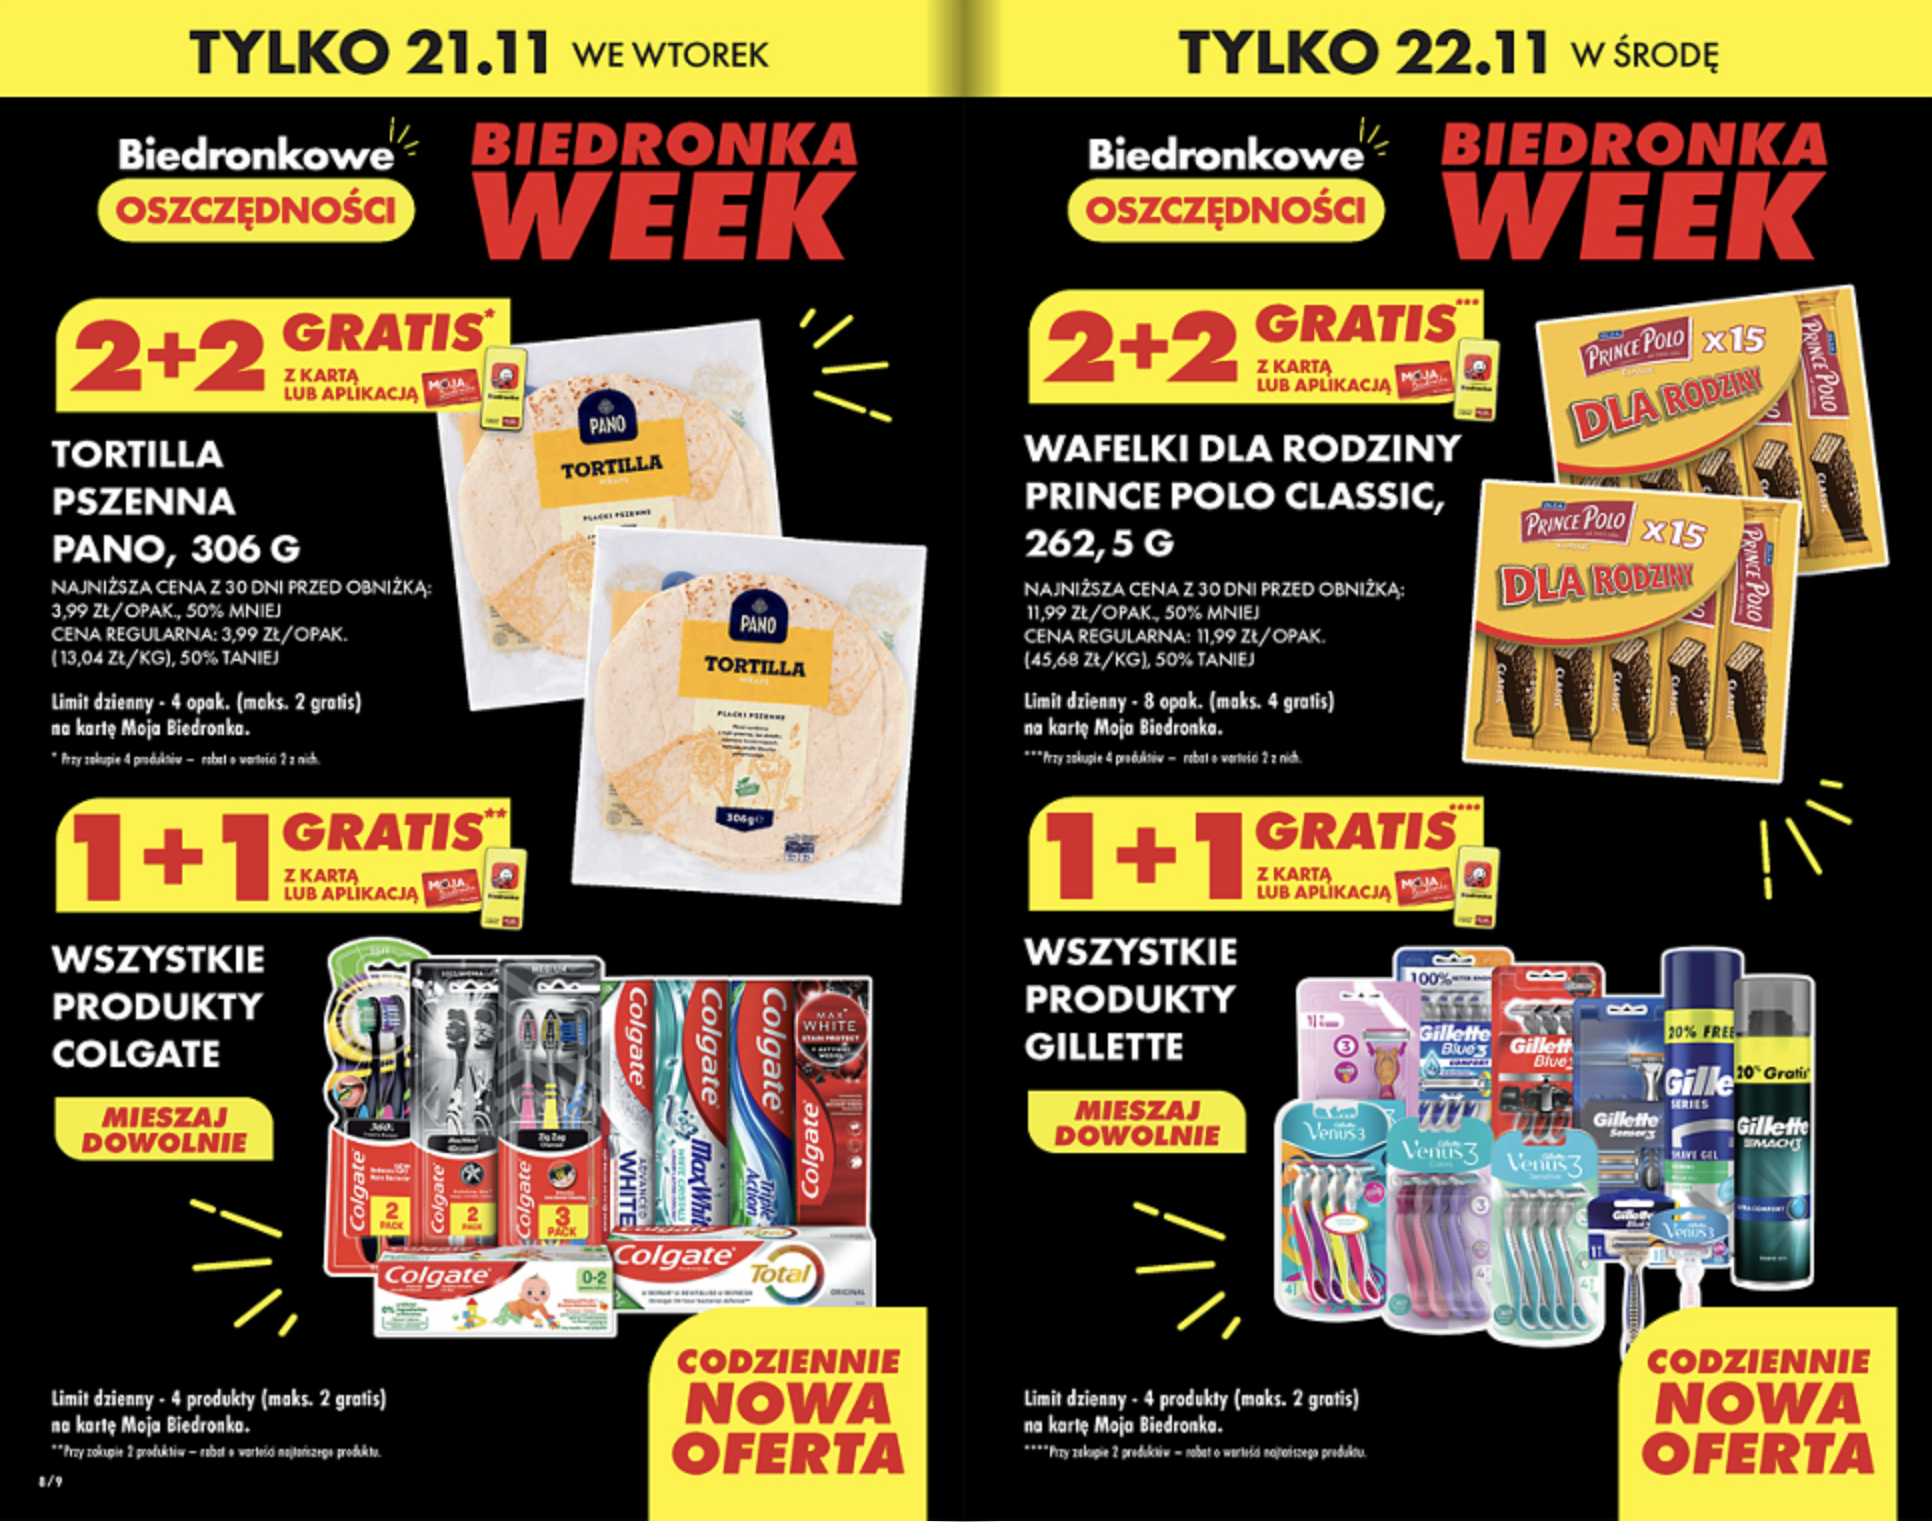

Tortilla Pszenna Pano, 306 g/Food/2+2 gratis/3.99 PLN (for 1 package before discount, 50% savings)
Wafelki dla Rodziny Prince Polo Classic, 262,5 g/Food/2+2 gratis/11.99 PLN (for 1 package before discount, 50% savings)
Wszystkie Produkty Colgate/Personal Care/1+1 gratis/Not specified
Wszystkie Produkty Gillette/Personal Care/1+1 gratis/Not specified


In [25]:
offer_strings = ''
for idx in range(10):
    response = chat(query , 'images/products1.png')
    offer_strings += response + '\n'

In [26]:
# Using StringIO to simulate a file-like object
string_io = StringIO(response.strip())

# Reading the string into a pandas DataFrame
df = pd.read_csv(string_io, sep="/", names=["Product", "Type", "Discount", "Price"])

df

,Product,Type,Discount,Price
0,"Tortilla Pszenna Pano, 306 g",Food,2+2 gratis,"3.99 PLN (for 1 package before discount, 50% s..."
1,"Wafelki dla Rodziny Prince Polo Classic, 262,5 g",Food,2+2 gratis,"11.99 PLN (for 1 package before discount, 50% ..."
2,Wszystkie Produkty Colgate,Personal Care,1+1 gratis,Not specified
3,Wszystkie Produkty Gillette,Personal Care,1+1 gratis,Not specified
